In [16]:
import sys
sys.path.append('../../')

import pandas as pd
from python_src.figures_utils import get_all_expected, generate_experimental_df, get_relabund_files, fully_combined, generate_cb
from dataclasses import dataclass
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import numpy as np
import datetime

from scipy.stats import f_oneway, kruskal, wilcoxon, mannwhitneyu, spearmanr, ttest_ind
from statsmodels.sandbox.stats.multicomp import multipletests
from matplotlib.legend_handler import HandlerTuple
from itertools import combinations

today = datetime.date.today()
date = today.strftime("%Y-%m-%d")

# Dataclass Initialization

In [17]:
@dataclass
class Pipeline:
    """
    This class will hold the parameters for each pipeline.
    Variables:
        root: str
            The root directory of the pipeline.
        inset: bool
            Whether or not to include an inset plot.
    """
    root: str
    inset: bool

    def __init__(self, root: str, inset: bool):
        self.root = root
        self.inset = inset

tourlousse = Pipeline("../../pipelines/tourlousse", False)
amos_hilo = Pipeline("../../pipelines/amos/hilo", False)
amos_mixed = Pipeline("../../pipelines/amos/mixed", False)
mbarc = Pipeline("../../pipelines/mbarc", False)

experiments = [tourlousse, amos_hilo, amos_mixed, mbarc]
# experiments = [tourlousse]

In [18]:
def fix_x_labels(ax, df, rank):
    """ Fix the x labels to be the species name rather than the TAX_ID. """
    xticks = ax.get_xticklabels()
    # print(xticks)
    new_labels = []
    for x in xticks:
        # res = df.loc[int(x.get_text()), rank]
        res = df.loc[df["TAX_ID"] == int(x.get_text()), rank]
        # Get only the first row from the series.
        # This is necessary because if it is unique, it will return a string, but if it is not unique, it will return a series.
        if isinstance(res, pd.Series):
            res = res.iloc[0]
        new_labels.append(res)

    return new_labels

In [19]:
cb_palette = generate_cb()

def make_title(rank: str, exp_name: str, thresh: float):
    """ Makes title from rank, exp_name, and threshold. """
    return f"Average Relative Abundance of {rank.capitalize()} in Experiement {exp_name.capitalize()} at Threshold {thresh}"

def plot_bars(thresh: float, rank: str = "genus"):

    for e in experiments:
        # Initialize the dataframe to hold the data.
        plt_df = pd.DataFrame()
        # Make the bigger figure.
        # fig = plt.figure(figsize=(15, 12))

        exp_name = e.root.split("/")[-1]

        # Get the data for the experiment.
        expected_root = e.root.replace("pipelines", "expected_pipelines")
        fc = fully_combined(root_dir=e.root, expected_root=expected_root, rank=rank)

        # Only select where Source is "expected", "bio4", or "jams202212".
        fc = fc.loc[fc["Source"].isin(["Expected", "biobakery4", "jams202212"])]
        # fc.to_csv(f"{rank}_{exp_name}_fc.csv", index=True)

        continue
        
        """        
        for pl, pl_df in fc.groupby("Source"):
            # Average the abundances on the same index values. This keeps the names of the taxa.
            averaged_df = pl_df.groupby(["TAX_ID", rank, "Source"]).mean(numeric_only=True)

            # Filter out the values that are below the threshold.
            averaged_df = averaged_df.loc[averaged_df["RA"] > thresh]

            # Add the data to the plot dataframe.
            plt_df = pd.concat([plt_df, averaged_df], axis=0)

            # pl_df.to_csv(f"genus_{pl}.csv", index=True)

        plt_df.reset_index(inplace=True)        

        # We want only bio4 and jams.
        plt_df = plt_df.loc[plt_df["Source"].isin(["Expected", "bio4", "jams"])]

        # Plot the data.
        ax = sns.barplot(x="TAX_ID", y='RA', hue="Source", data=plt_df, errorbar=None, log=True, palette=cb_palette)
        ax.set_xticklabels(fix_x_labels(ax=ax, df=plt_df, rank=rank), rotation=45, horizontalalignment='right')

        # Make the title and add the axes labels.
        ax.set_title(make_title(rank, exp_name, thresh))
        ax.set_xlabel(rank.capitalize())
        ax.set_ylabel('Average Relative Abundance')

        # Save the plt_df.
        # plt_df.to_csv(f"{rank}_{exp_name}_{thresh}.csv", index=False)
        """

# plot_bars(0.0001, "species")
# plot_bars(0.0001, "genus")

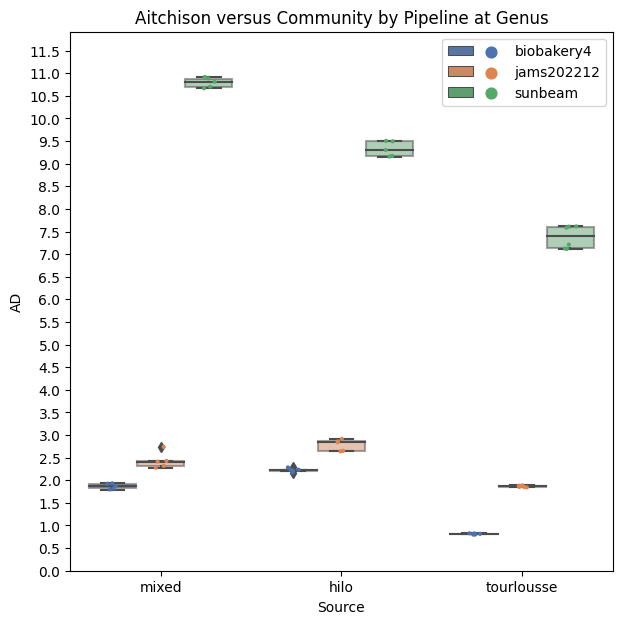

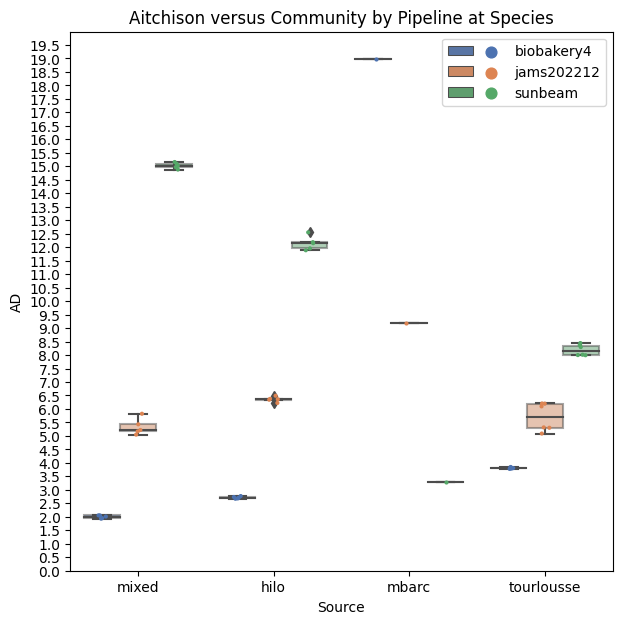

In [23]:
# Creation of Statistical Analysis Plots
stats_path_genus = os.path.abspath(f"../../utils/analysis/results/all_stats_genus.csv")
stats_path_species = os.path.abspath(f"../../utils/analysis/results/all_stats_species.csv")
stats_paths = [stats_path_genus, stats_path_species]

def decorate_plot(g: plt.Axes, df: pd.DataFrame, rank: str):
    g.set(ylim=(0, df["AD"].max() + 1))
    g.set(title=f"Aitchison versus Community by Pipeline at {rank.capitalize()}")
    g.set(yticks=np.arange(0, df["AD"].max() + 1, 0.5))

WANTED_COMMUNITIES = ["tourlousse", "mixed", "hilo", "mbarc"]
WANTED_PIPELINES = ["biobakery4", "jams202212", "sunbeam"]

def non_avg_stats(threshold: float, stats_paths: list):
    for stats_path in stats_paths:
        rank = stats_path.split("/")[-1].split("_")[2].split(".")[0]
        stats_df = pd.DataFrame()

        # print(stats_path)
        df = pd.read_csv(stats_path)
        df = df.loc[df["Source"].isin(WANTED_COMMUNITIES)]
        df = df.loc[df["Pipeline"].isin(WANTED_PIPELINES)]
        df = df.loc[(df["threshold"] == threshold)]

        fig = plt.figure(figsize=(7,7))
        g = sns.boxplot(x="Source", y="AD", hue="Pipeline", data=df, palette="deep", dodge=True, boxprops={'alpha': 0.5})
        sns.stripplot(x="Source", y="AD", hue="Pipeline", data=df, palette="deep", dodge=True, size=3, linewidth=0)

        decorate_plot(g, df, rank)

        handles, labels = g.get_legend_handles_labels()
        g.legend(handles=[(handles[0], handles[3]), (handles[1], handles[4]), (handles[2], handles[5])],
          labels=['biobakery4', 'jams202212', 'sunbeam'],
          loc='upper right', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)})
        
        # Save the plot.
        plt.savefig(f"{rank}_box.png", dpi=300)

        plt.show()

        for src, src_df in df.groupby("Source"):
            # print(src_df.columns)
            # Pivot the Pipeline values to columns.
            # piv_df = src_df.pivot(index="SampleID", columns="Pipeline", values="AD")
            # display(piv_df)
            # # Do wilcoxon on the three permutations.
            # pairs = list(combinations(piv_df.columns, 2))
            # for pair in pairs:
            #     print(pair)
            #     h, p = wilcoxon(piv_df[pair[0]].values, piv_df[pair[1]].values) 
            #     print(h, p)
            for pl, pl_df in src_df.groupby("Pipeline"):
                # pl_df.loc["Average"] = pl_df.mean(numeric_only=True)
                avg = pl_df.mean(numeric_only=True)
                std = pl_df.std(numeric_only=True)

                avg_cols = avg.keys()
                avg_cols = ["Pipeline", "Community"] + avg_cols.to_list()

                new_line = [f"{val:.2f} +- {std[c]:.2f}" for c, val in enumerate(avg)]
                new_line.insert(0, src)
                new_line.insert(0, pl)
                stats_df = pd.concat([stats_df, pd.DataFrame(new_line, index=avg_cols).T])

        stats_df = stats_df[["Pipeline", "Community", "AD", "Sens", "FPRA"]]
        rename_dict = {"AD": "Mean AD +- Stdev", "Sens": "Mean Sens +- Stdev (%)", "FPRA": "Mean FPRA +- Stdev (%)"}
        stats_df.rename(rename_dict, inplace=True, axis=1)

        stats_df.to_csv(f"{rank}_stats.csv", index=False, encoding="cp1252")
    
non_avg_stats(0.0001, stats_paths=stats_paths)

## Cleaning of Stats Output
The stats output currently has some +- characters in the line, which render oddly and seem like they could be annoying.
To fix this, we are going to read it in, then split it.

In [34]:
JOHN_SPECIES_PATH = "species_stats.csv"
JOHN_GENUS_PATH = "genus_stats.csv"

def clean_stats_output(input_fp: str) -> None:
    rank = input_fp.split("_")[0]

    df = pd.read_csv(input_fp)

    # Split the 2nd column into two columns.
    df[["Mean AD", "Stdev AD"]] = df["Mean AD +- Stdev"].str.split("\+\-", expand=True)
    df[["Mean Sens", "Stdev Sens"]] = df["Mean Sens +- Stdev (%)"].str.split("\+\-", expand=True)
    df[["Mean FPRA", "Stdev FPRA"]] = df["Mean FPRA +- Stdev (%)"].str.split("\+\-", expand=True)

    # Drop the old columns.
    df.drop(["Mean AD +- Stdev", "Mean Sens +- Stdev (%)", "Mean FPRA +- Stdev (%)"], axis=1, inplace=True)
    
    # Save the new df.
    df.to_csv(f"cleaned_{rank}_stats.csv", index=False)

    display(df)

clean_stats_output(JOHN_SPECIES_PATH)
clean_stats_output(JOHN_GENUS_PATH)

,Pipeline,Community,Mean AD,Stdev AD,Mean Sens,Stdev Sens,Mean FPRA,Stdev FPRA
0,biobakery4,hilo,2.71,0.04,100.00,0.00,0.00,0.00
1,jams202212,hilo,6.36,0.10,63.16,0.00,0.00,0.00
2,sunbeam,hilo,12.14,0.26,89.47,0.00,0.60,0.00
3,biobakery4,mbarc,18.99,nan,92.00,nan,7.95,nan
4,jams202212,mbarc,9.18,nan,40.00,nan,0.00,nan
5,sunbeam,mbarc,3.30,nan,100.00,nan,0.00,nan
6,biobakery4,mixed,2.00,0.06,100.00,0.00,0.00,0.00
7,jams202212,mixed,5.34,0.30,100.00,0.00,1.53,0.09
8,sunbeam,mixed,15.02,0.11,89.47,0.00,4.64,0.07
9,biobakery4,tourlousse,3.81,0.02,94.74,0.00,4.72,0.04


,Pipeline,Community,Mean AD,Stdev AD,Mean Sens,Stdev Sens,Mean FPRA,Stdev FPRA
0,biobakery4,hilo,2.23,0.04,100.00,0.00,0.00,0.00
1,jams202212,hilo,2.78,0.13,68.75,0.00,0.00,0.00
2,sunbeam,hilo,9.33,0.17,100.00,0.00,0.57,0.02
3,biobakery4,mixed,1.87,0.06,100.00,0.00,0.00,0.00
4,jams202212,mixed,2.43,0.18,100.00,0.00,0.00,0.00
5,sunbeam,mixed,10.80,0.11,100.00,0.00,1.79,0.03
6,biobakery4,tourlousse,0.81,0.01,100.00,0.00,0.00,0.00
7,jams202212,tourlousse,1.86,0.02,100.00,0.00,0.00,0.00
8,sunbeam,tourlousse,7.38,0.25,100.00,0.00,0.64,0.01
